# Crossentropy method

This notebook will teach you to solve reinforcement learning problems with crossentropy method. We'll follow-up by scaling everything up and using neural network policy.

In [6]:
import os


In [7]:
import gym
import numpy as np, pandas as pd

env = gym.make("Taxi-v3", render_mode="rgb_array")
env.reset()
env.render()
# render_mode="rgb_array"
# render_mode="human"

array([[[110, 109, 106],
        [110, 109, 106],
        [124, 122, 122],
        ...,
        [108, 111, 109],
        [108, 111, 109],
        [118, 119, 119]],

       [[110, 109, 106],
        [110, 109, 106],
        [124, 122, 122],
        ...,
        [108, 111, 109],
        [108, 111, 109],
        [118, 119, 119]],

       [[114, 116, 115],
        [114, 116, 115],
        [126, 127, 126],
        ...,
        [112, 113, 111],
        [112, 113, 111],
        [118, 117, 115]],

       ...,

       [[116, 115, 116],
        [116, 115, 116],
        [106, 107, 108],
        ...,
        [113, 115, 114],
        [113, 115, 114],
        [117, 114, 117]],

       [[116, 115, 116],
        [116, 115, 116],
        [106, 107, 108],
        ...,
        [113, 115, 114],
        [113, 115, 114],
        [117, 114, 117]],

       [[115, 112, 112],
        [115, 112, 112],
        [119, 119, 117],
        ...,
        [123, 119, 118],
        [123, 119, 118],
        [114, 114, 117]]

In [8]:
n_states = env.observation_space.n
n_actions = env.action_space.n

print("n_states=%i, n_actions=%i"%(n_states,n_actions))

n_states=500, n_actions=6


# Create stochastic policy

This time our policy should be a probability distribution.

```policy[s,a] = P(take action a | in state s)```

Since we still use integer state and action representations, you can use a 2-dimensional array to represent the policy.

Please initialize policy __uniformly__, that is, probabililities of all actions should be equal.


# Initialize policy (0.5pts)

In [9]:
import numpy as np

policy = np.full((n_states, n_actions), 1.0/n_actions)
assert type(policy) in (np.ndarray,np.matrix)
assert np.allclose(policy,1./n_actions)
assert np.allclose(np.sum(policy,axis=1), 1)
print("Ok!")

Ok!


# Play the game (0.5pts)

Just like before, but we also record all states and actions we took.

In [10]:
def generate_session(policy,t_max=10**4):
    """
    Play game until end or for t_max ticks.
    :param policy: an array of shape [n_states,n_actions] with action probabilities
    :returns: list of states, list of actions and sum of rewards
    """
    states,actions = [],[]
    total_reward = 0.
    
    s = env.reset()[0]
    
    for t in range(t_max):
        a = np.random.choice(range(n_actions), p = policy[s])   #range(n_actions) -  список чисел от 1 до / выбирает действие от 1 до n с вероятностью p
        
        new_s,r,done,_,_ = env.step(a)
        actions.append(a)
        states.append(s)
        total_reward += r  
        s = new_s

        #Record state, action and add up reward to states,actions and total_reward accordingly. 
        #add state
        #add action
        #add reward
        
        if done:
            break
    return states,actions,total_reward
        

In [12]:
s,a,r = generate_session(policy)
assert type(s) == type(a) == list
assert len(s) == len(a)
assert type(r) in [float]

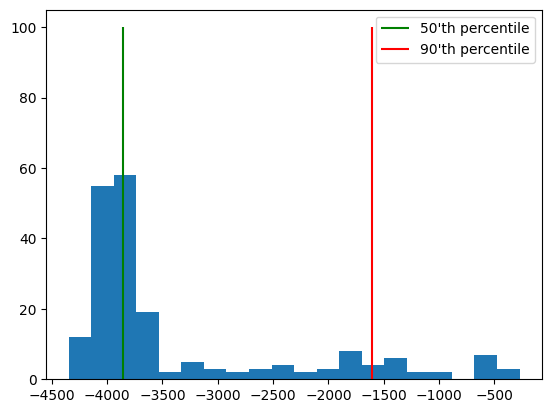

In [13]:
#let's see the initial reward distribution
import matplotlib.pyplot as plt
%matplotlib inline

sample_rewards = [generate_session(policy,t_max=1000)[-1] for _ in range(200)]

plt.hist(sample_rewards,bins=20)
plt.vlines([np.percentile(sample_rewards,50)],[0],[100],label="50'th percentile",color='green')
plt.vlines([np.percentile(sample_rewards,90)],[0],[100],label="90'th percentile",color='red')
plt.legend()

### Crossentropy method steps (1pts)

In [14]:
def select_elites(states_batch,actions_batch,rewards_batch,percentile=percentile):
    """
    Select states and actions from games that have rewards >= percentile
    :param states_batch: list of lists of states, states_batch[session_i][t]
    :param actions_batch: list of lists of actions, actions_batch[session_i][t]
    :param rewards_batch: list of rewards, rewards_batch[session_i][t]
    
    :returns: elite_states,elite_actions, both 1D lists of states and respective actions from elite sessions
    
    Please return elite states and actions in their original order 
    [i.e. sorted by session number and timestep within session]
    
    If you're confused, see examples below. Please don't assume that states are integers (they'll get different later).
    """ 
    reward_threshold = np.percentile(rewards_batch, percentile)
    
    elite_states = []
    elite_actions = []
    for i in range(len(rewards_batch)):  
        if rewards_batch[i] >= reward_threshold:  
            elite_states.append(states_batch[i])  
            elite_actions.append(actions_batch[i]) 
    if(len(np.array(states_batch[0]).shape) == 1):
        elite_states = np.hstack(elite_states)
    else:
        elite_states = np.vstack(elite_states)
    elite_actions = np.hstack(elite_actions)
    
    return elite_states,elite_actions
    

In [15]:
states_batch = [
    np.array([1,2,3]),   # game1
    np.array([4,2,0,2]), # game2
    np.array([3,1])      # game3
]

actions_batch = [
    np.array([0,2,4]),   # game1
    np.array([3,2,0,1]), # game2
    np.array([3,3])      # game3
]
rewards_batch = np.array([
    3,         #game1
    4,         #game2
    5,         #game3
])

test_result_0 = select_elites(states_batch,actions_batch,rewards_batch,percentile=0)
test_result_40 = select_elites(states_batch,actions_batch,rewards_batch,percentile=30)
test_result_90 = select_elites(states_batch,actions_batch,rewards_batch,percentile=90)
test_result_100 = select_elites(states_batch,actions_batch,rewards_batch,percentile=100)

assert np.all(test_result_0[0] == [1, 2, 3, 4, 2, 0, 2, 3, 1])  \
   and np.all(test_result_0[1] == [0, 2, 4, 3, 2, 0, 1, 3, 3]),\
        "For percentile 0 you should return all states and actions in chronological order"
assert np.all(test_result_40[0] == [4, 2, 0, 2, 3, 1]) and \
        np.all(test_result_40[1] ==[3, 2, 0, 1, 3, 3]),\
        "For percentile 30 you should only select states/actions from two first"
assert np.all(test_result_90[0] == [3,1]) and \
        np.all(test_result_90[1] == [3,3]),\
        "For percentile 90 you should only select states/actions from one game"
assert np.all(test_result_100[0] == [3,1]) and\
       np.all(test_result_100[1] == [3,3]),\
        "Please make sure you use >=, not >. Also double-check how you compute percentile."
print("Ok!")

Ok!


In [16]:
def update_policy(elite_states,elite_actions):
    """
    Given old policy and a list of elite states/actions from select_elites,
    return new updated policy where each action probability is proportional to
    
    policy[s_i,a_i] ~ #[occurences of si and ai in elite states/actions]
    
    Don't forget to normalize policy to get valid probabilities and handle 0/0 case.
    In case you never visited a state, set probabilities for all actions to 1./n_actions
    
    :param elite_states: 1D list of states from elite sessions
    :param elite_actions: 1D list of actions from elite sessions
    
    """
    new_policy = np.zeros([n_states,n_actions])
    
    for s, a in zip(elite_states, elite_actions):
        new_policy[s, a] += 1
    
    for s in range(n_states):
        if new_policy[s].sum() > 0:
            new_policy[s] /= new_policy[s].sum()
        else:
            new_policy[s] = 1. / n_actions

    return new_policy

In [17]:

elite_states, elite_actions = ([1, 2, 3, 4, 2, 0, 2, 3, 1], [0, 2, 4, 3, 2, 0, 1, 3, 3])


new_policy = update_policy(elite_states,elite_actions)

assert np.isfinite(new_policy).all(), "Your new policy contains NaNs or +-inf. Make sure you don't divide by zero."
assert np.all(new_policy>=0), "Your new policy can't have negative action probabilities"
assert np.allclose(new_policy.sum(axis=-1),1), "Your new policy should be a valid probability distribution over actions"
reference_answer = np.array([
       [ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.5       ,  0.        ,  0.        ,  0.5       ,  0.        ],
       [ 0.        ,  0.33333333,  0.66666667,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.5       ,  0.5       ]])
print(new_policy[:4,:5])
assert np.allclose(new_policy[:4,:5],reference_answer)
print("Ok!")

[[1.         0.         0.         0.         0.        ]
 [0.5        0.         0.         0.5        0.        ]
 [0.         0.33333333 0.66666667 0.         0.        ]
 [0.         0.         0.         0.5        0.5       ]]
Ok!


# Training loop (1pts)
Generate sessions, select N best and fit to those.

In [18]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

def show_progress(rewards_batch,log, reward_range=[-990,+10]):
    """
    A convenience function that displays training progress. 
    No cool math here, just charts.
    """
    
    mean_reward = np.mean(rewards_batch)
    threshold = np.percentile(rewards_batch, percentile)
    log.append([mean_reward, threshold])

    clear_output(True)  
    print(f"Mean reward = {mean_reward:.3f}, threshold = {threshold:.3f}")

    plt.figure(figsize=[8, 4])

    plt.subplot(1, 2, 1)
    plt.plot([l[0] for l in log], label='Mean rewards')
    plt.plot([l[1] for l in log], label='Reward thresholds')
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.hist(rewards_batch, range=reward_range, bins=20, alpha=0.7)
    plt.axvline(threshold, color='red', linestyle='dashed', label="percentile")
    plt.legend()
    plt.grid()

    plt.show()


In [19]:
#reset policy just in case
policy = np.ones((n_states, n_actions)) / n_actions  


Mean reward = -1555.312, threshold = 7.000


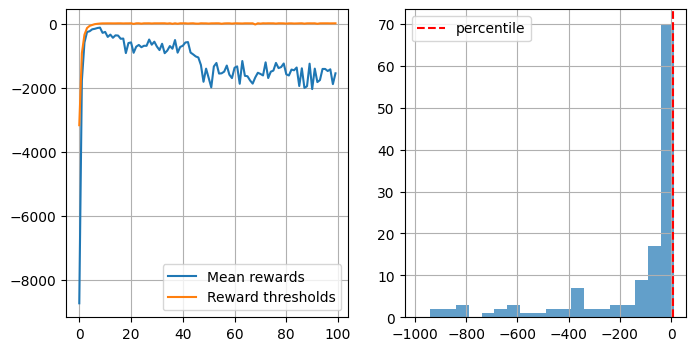

In [20]:
n_sessions = 250  # sample this many sessions
percentile = 70  # take this percent of session with highest rewards
learning_rate = 0.5  # smoothing factor to stabilize training

log = []

for i in range(100):
    sessions = [generate_session(policy) for _ in range(n_sessions)]
    states_batch, actions_batch, rewards_batch = zip(*sessions)
    
    elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile=percentile)
    new_policy = update_policy(elite_states, elite_actions)
    
    policy = new_policy
    
    # display results on chart
    show_progress(rewards_batch, log)


# Tabular crossentropy method

You may have noticed that the taxi problem quickly converges from -100 to a near-optimal score and then descends back into -50/-100. This is in part because the environment has some innate randomness. Namely, the starting points of passenger/driver change from episode to episode.

### Tasks
- __1.1__ (1 pts) Find out how the algorithm performance changes if you change different percentile and different n_samples. Show all precentiles on one graph and all n_samples on another
- __1.2__ (1 pts) Tune the algorithm to end up with positive average score.

It's okay to modify the existing code.


In [30]:
# import gym
# import numpy as np, pandas as pd

# env = gym.make("Taxi-v2")
# env.reset()
# n_states = env.observation_space.n
# n_actions = env.action_space.n
# policy = 1/6. * np.ones([n_states, n_actions])
# assert type(policy) in (np.ndarray,np.matrix)
# assert np.allclose(policy,1./n_actions)
# assert np.allclose(np.sum(policy,axis=1), 1)
# s,a,r = generate_session(policy)
# assert type(s) == type(a) == list
# assert len(s) == len(a)
# assert type(r) in [float,np.float]
# policy = np.ones([n_states,n_actions])/n_actions 
# stepCounter = 40
import gym
import numpy as np

env = gym.make("Taxi-v3", render_mode="rgb_array")
n_states = env.observation_space.n
n_actions = env.action_space.n

policy = np.ones([n_states, n_actions]) / n_actions
assert np.allclose(policy, 1. / n_actions)
assert np.allclose(np.sum(policy, axis=1), 1)

def generate_session(policy, t_max=1000):
    states, actions = [], []
    total_reward = 0.0
    s, _ = env.reset()  
    for t in range(t_max):
        a = np.random.choice(range(n_actions), p=policy[s])  
        step_result = env.step(a)
        if len(step_result) == 4:
            new_s, r, done, info = step_result
            truncated = False  
        else:
            new_s, r, done, truncated, info = step_result  
        states.append(s)
        actions.append(a)
        total_reward += r
        s = new_s
        if done:
            break
    return states, actions, total_reward


stepCounter = 40



In [32]:
s, a, r = generate_session(policy)
assert type(s) == type(a) == list
assert len(s) == len(a)
assert isinstance(r, (float, float)) 

90


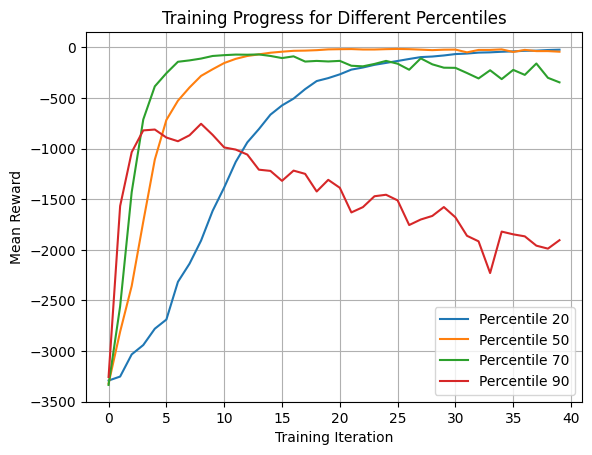

In [25]:
# n_sessions = 250  #sample this many sessions
# percentiles = []  #take this percent of session with highest rewards
# learning_rate = 0.5  #add this thing to all counts for stability

# log = []
# mean = []
# for percentile in percentiles:
#     curMean = []
#     policy = np.ones([n_states,n_actions])/n_actions
#     for i in range(stepCounter):

#         %time sessions = [generate_session(policy) for _ in range(n_sessions)]

#         states_batch,actions_batch,rewards_batch = zip(*sessions)

#         elite_states, elite_actions = select_elites(np.array(states_batch),np.array(actions_batch),np.array(rewards_batch),percentile=50)

#         #set new policy
#         #update policy
#         #add mean value
#         clear_output(True)
#     mean.append(curMean)
#     #display results on chart
#     #show_progress(rewards_batch,log)
n_sessions = 250
percentiles = [20, 50, 70, 90]  
learning_rate = 0.5

log = []
mean = []

for percentile in percentiles:
    curMean = []
    policy = np.ones([n_states, n_actions]) / n_actions  

    for i in range(stepCounter):
        sessions = [generate_session(policy) for _ in range(n_sessions)]

        states_batch, actions_batch, rewards_batch = zip(*sessions)
        elite_states, elite_actions = select_elites(
            states_batch,  
            actions_batch,
            rewards_batch,
            percentile=percentile
        )

        new_policy = update_policy(elite_states, elite_actions)
        policy = learning_rate * new_policy + (1 - learning_rate) * policy  

        curMean.append(np.mean(rewards_batch))  

        clear_output(True)  

    mean.append(curMean)

    plt.plot(curMean, label=f"Percentile {percentile}")
    print(percentile)

plt.xlabel("Training Iteration")
plt.ylabel("Mean Reward")
plt.title("Training Progress for Different Percentiles")
plt.legend()
plt.grid()
plt.show()

# How do different percentiles affect training efficiency?

# Describe your observations
Довольно высокие процентили быстро достигают хороших результатов (примерно за 10 итераций), а также они довольно стабильны.
Низкий 20 процентный процентиль медленне достигает хороших результатов (примерно 25 итераций ), однако он очень стабилен.
Высокий процентиль (90) сначало очень быстро растет, но затем начинает падать, показывая плохие результаты. То есть для быстрых результатов выгоднее выбирать процентиль от 50-75, а для стабильности ниже 50.

In [35]:
# n_sessions_ar = []  #sample this many sessions
# perc = 70  #take this percent of session with highest rewards
# learning_rate = 0.5  #add this thing to all counts for stability

# log = []
# mean = []
# for n_sessions in n_sessions_ar:
#     curMean = []
#     policy = np.ones([n_states,n_actions])/n_actions
#     for i in range(stepCounter):

#         %time sessions = [generate_session(policy) for _ in range(n_sessions)]

#         states_batch,actions_batch,rewards_batch = zip(*sessions)

#         elite_states, elite_actions = select_elites(np.array(states_batch),
#                                                     np.array(actions_batch),np.array(rewards_batch),percentile=perc)

#         #set new policy
#         #update policy
#         #add mean value
#         clear_output(True)
#     mean.append(curMean)
#     #display results on chart
#     #show_progress(rewards_batch,log)
import gym
import numpy as np
import pandas as pd
import time
from IPython.display import clear_output
import matplotlib.pyplot as plt
env = gym.make("Taxi-v3", render_mode="rgb_array")

n_sessions_ar = [100, 200, 300, 400, 500]  
perc = 70 
learning_rate = 0.5  
stepCounter = 40

log = []
mean = []
n_states = env.observation_space.n
n_actions = env.action_space.n

for n_sessions in n_sessions_ar:
    curMean = []
    policy = np.ones([n_states, n_actions]) / n_actions

    for i in range(stepCounter):
        start_time = time.time()
        sessions = [generate_session(policy) for _ in range(n_sessions)]
        print(f"Iteration {i}, n_sessions={n_sessions}: {time.time() - start_time:.4f} sec")

        states_batch, actions_batch, rewards_batch = zip(*sessions)

        elite_states, elite_actions = select_elites((states_batch),
                                                    (actions_batch), 
                                                    (rewards_batch), 
                                                    percentile=perc)

        new_policy = np.ones([n_states, n_actions]) * learning_rate
        for state, action in zip(elite_states, elite_actions):
            new_policy[state, action] += 1
        new_policy /= new_policy.sum(axis=1, keepdims=True)  

        policy = new_policy 

        curMean.append(np.mean(rewards_batch))
        clear_output(True)
    
    mean.append(curMean)

for i, m in enumerate(mean):
    plt.plot(m, label=f"n_sessions={n_sessions_ar[i]}")
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Mean Reward")
plt.title("Performance with Different n_sessions")
plt.show()


AttributeError: module 'numpy' has no attribute 'bool8'

# Stabilize positive rewards by averaging policy across 10 games (2 pts)

In [ ]:
def generate_session(policy,t_max=10**4):
    """
    Play game until end or for t_max ticks.
    :param policy: an array of shape [n_states,n_actions] with action probabilities
    :returns: list of states, list of actions and sum of rewards
    """
    states,actions = [],[]
    total_reward = 0.
    
    #code here
    return states,actions,total_reward
        

In [5]:
n_sessions = 75  #sample this many sessions
percentile = 70  #take this percent of session with highest rewards
learning_rate = 0.2  #add this thing to all counts for stability

log = []
mean = []
policy = np.ones([n_states,n_actions])/n_actions
for i in range(1000):

    %time sessions = [generate_session(policy) for _ in range(n_sessions)]

    states_batch,actions_batch,rewards_batch = zip(*sessions)

    elite_states, elite_actions = select_elites(np.array(states_batch),np.array(actions_batch),np.array(rewards_batch),percentile=50)

    #code here

    show_progress(rewards_batch,log)
    
    if(np.mean(rewards_batch) > 7):
        print("win!")
        break

NameError: name 'generate_session' is not defined

NameError: name 'sessions' is not defined

# Digging deeper: approximate crossentropy with neural nets (2 pts)

In this section we will train a neural network policy for continuous state space game

In [ ]:
import gym
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
env = gym.make("CartPole-v0").env  #if you see "<classname> has no attribute .env", remove .env or update gym

env.reset()
n_actions = env.action_space.n

plt.imshow(env.render("rgb_array"))

In this case use NN as a black box. All your should know that it is more complex than a tabular method. 

In [ ]:
#create agent
from sklearn.neural_network import MLPClassifier
agent = MLPClassifier(hidden_layer_sizes=(20,20),
                      activation='tanh',
                      warm_start=True, #keep progress between .fit(...) calls
                      max_iter=1 #make only 1 iteration on each .fit(...)
                     )
#initialize agent to the dimension of state an amount of actions
agent.fit([env.reset()]*n_actions,range(n_actions));


In [ ]:
def generate_session(t_max=1000):
    
    states,actions = [],[]
    total_reward = 0
    
    s = env.reset()
    
    for t in range(t_max):
        
        #predict array of action probabilities hint: predict_proba
        
        
        a = np.random.choice(np.arange(n_actions), p=probs)
        
        new_s,r,done,info = env.step(a)
        
        #record sessions like you did before
        
        
        s = new_s
        if done: break
    return states,actions,total_reward
        

In [ ]:
def select_elites(states_batch,actions_batch,rewards_batch,percentile=50):
    """
    Select states and actions from games that have rewards >= percentile
    :param states_batch: list of lists of states, states_batch[session_i][t]
    :param actions_batch: list of lists of actions, actions_batch[session_i][t]
    :param rewards_batch: list of rewards, rewards_batch[session_i][t]
    
    :returns: elite_states,elite_actions, both 1D lists of states and respective actions from elite sessions
    
    Please return elite states and actions in their original order 
    [i.e. sorted by session number and timestep within session]
    
    If you're confused, see examples below. Please don't assume that states are integers (they'll get different later).
    """ 
    reward_threshold = np.percentile(rewards_batch,percentile)
    
    elite_states = []
    
    if(len(np.array(states_batch[0]).shape) == 1):
        elite_states = np.hstack(states_batch[rewards_batch >= reward_threshold])
    else:
        elite_states = np.vstack(states_batch[rewards_batch >= reward_threshold])
    elite_actions = np.hstack(actions_batch[rewards_batch >= reward_threshold])
    
    return elite_states,elite_actions
    

To train this classification model use fit(states, actions). In this case we are training classificator to predict the correct class (action) in a given state

In [ ]:
n_sessions = 100
percentile = 70
log = []

for i in range(100):
    #generate new sessions
    sessions = [generate_session() for _ in range(n_sessions)]

    states_batch,actions_batch,rewards_batch = map(np.array,zip(*sessions))
    print(states_batch.shape)

    elite_states, elite_actions = select_elites(states_batch,actions_batch,rewards_batch,percentile=50)
    
    #fit agent

    show_progress(rewards_batch,log,reward_range=[0,np.max(rewards_batch)])
    
    if np.mean(rewards_batch)> 190:
        print("You Win! You may stop training now via KeyboardInterrupt.")
        break

# Report (1 pts)

In [ ]:
# Describe what you did here.  Preferably with plot/report to support it